# essemble analysis

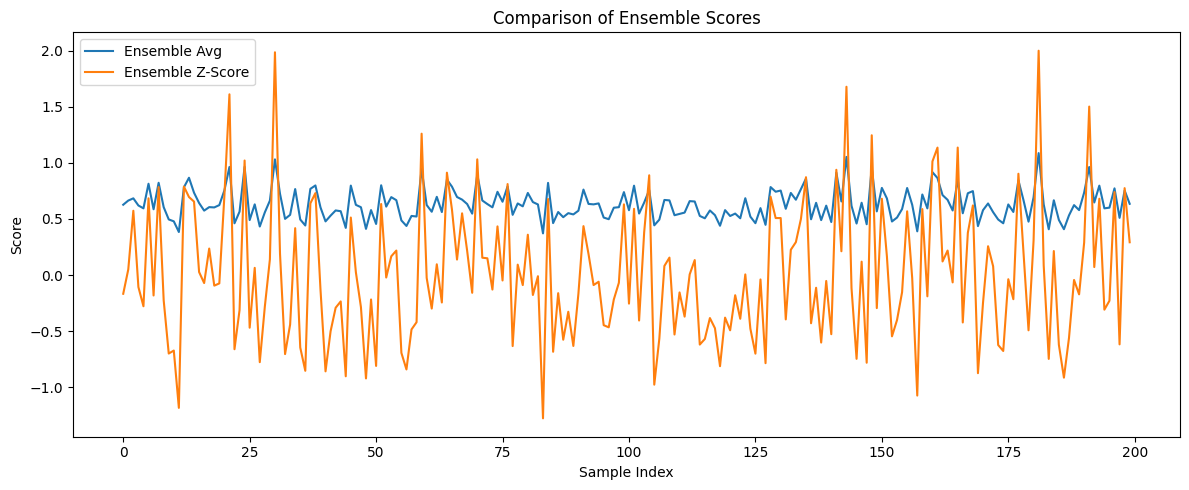

🔍 Common Top-K Anomalous Indices: [7, 21, 24, 30, 59, 64, 70, 135, 141, 143, 148, 160, 161, 165, 177, 181, 191]


In [1]:
# Ensemble Anomaly Detection Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load scores
vae_scores = np.load("vae_scores.npy")
tvae_scores = np.load("tvae_scores.npy")
diff_scores = np.load("diff_mae_scores.npy")

# Combine scores
def zscore(x):
    return (x - np.mean(x)) / (np.std(x) + 1e-8)

ensemble_avg = (vae_scores + tvae_scores + diff_scores) / 3
ensemble_z = (zscore(vae_scores) + zscore(tvae_scores) + zscore(diff_scores)) / 3

# Top-K comparison
K = 20
topk_avg_indices = np.argsort(-ensemble_avg)[:K]
topk_z_indices = np.argsort(-ensemble_z)[:K]
common_topk_indices = np.intersect1d(topk_avg_indices, topk_z_indices)

# Save results
result_df = pd.DataFrame({
    "Index": np.arange(len(vae_scores)),
    "VAE_Score": vae_scores,
    "TVAE_Score": tvae_scores,
    "Diff_Score": diff_scores,
    "Ensemble_Avg": ensemble_avg,
    "Ensemble_Z": ensemble_z,
    "TopK_Avg": [i in topk_avg_indices for i in range(len(vae_scores))],
    "TopK_Z": [i in topk_z_indices for i in range(len(vae_scores))],
    "Common_TopK": [i in common_topk_indices for i in range(len(vae_scores))]
})
result_df.to_csv("ensemble_anomaly_scores.csv", index=False)

# Visualization
plt.figure(figsize=(12, 5))
plt.plot(ensemble_avg, label="Ensemble Avg")
plt.plot(ensemble_z, label="Ensemble Z-Score")
plt.title("Comparison of Ensemble Scores")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.savefig("ensemble_score_comparison.png")
plt.show()

# Show common top-k
print("🔍 Common Top-K Anomalous Indices:", common_topk_indices.tolist())


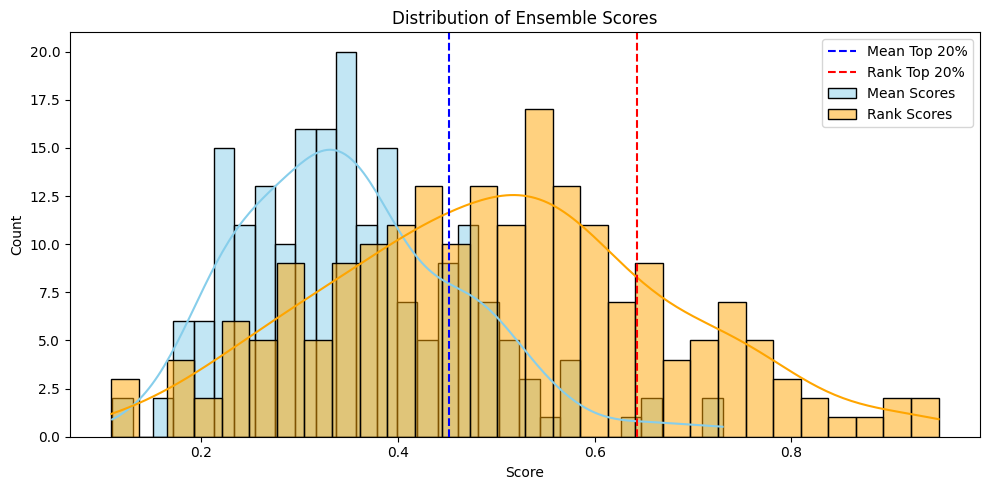

array([  5,   7,  12,  14,  20,  21,  24,  30,  37,  38,  51,  59,  64,
        65,  70,  76,  84,  99, 104, 128, 135, 141, 143, 148, 150, 161,
       165, 168, 177, 181, 191, 193])

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import rankdata
import os

# Load scores
vae_scores = np.load("vae_scores.npy")
tvae_scores = np.load("tvae_scores.npy")
diff_scores = np.load("diff_mae_scores.npy")

# 方法1：EnsembleMean（先归一化）
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())

vae_norm = normalize(vae_scores)
tvae_norm = normalize(tvae_scores)
diff_norm = normalize(diff_scores)

ensemble_mean_scores = (vae_norm + tvae_norm + diff_norm) / 3

# 方法2：EnsembleRank（百分位排名）
vae_rank = rankdata(vae_scores, method='average') / len(vae_scores)
tvae_rank = rankdata(tvae_scores, method='average') / len(tvae_scores)
diff_rank = rankdata(diff_scores, method='average') / len(diff_scores)

ensemble_rank_scores = (vae_rank + tvae_rank + diff_rank) / 3

# 设置 top 20% 阈值
top_k = int(0.2 * len(vae_scores))
mean_topk_idx = np.argsort(-ensemble_mean_scores)[:top_k]
rank_topk_idx = np.argsort(-ensemble_rank_scores)[:top_k]

# 两者都认为是异常的前 K 个样本
common_topk_idx = np.intersect1d(mean_topk_idx, rank_topk_idx)

# 保存结果
np.save("ensemble_mean_scores.npy", ensemble_mean_scores)
np.save("ensemble_rank_scores.npy", ensemble_rank_scores)
np.save("common_topk_idx.npy", common_topk_idx)

# 生成可视化数据表
df_result = pd.DataFrame({
    "VAE": vae_scores,
    "TVAE": tvae_scores,
    "Diffusion": diff_scores,
    "EnsembleMean": ensemble_mean_scores,
    "EnsembleRank": ensemble_rank_scores
})
df_result["mean_anomaly"] = False
df_result["rank_anomaly"] = False
df_result["both_topk"] = False
df_result.loc[mean_topk_idx, "mean_anomaly"] = True
df_result.loc[rank_topk_idx, "rank_anomaly"] = True
df_result.loc[common_topk_idx, "both_topk"] = True

# 保存 CSV
csv_path = "ensemble_anomaly_results.csv"
df_result.to_csv(csv_path, index=False)

# 可视化差异
plt.figure(figsize=(10, 5))
sns.histplot(ensemble_mean_scores, bins=30, color='skyblue', label='Mean Scores', kde=True)
sns.histplot(ensemble_rank_scores, bins=30, color='orange', label='Rank Scores', kde=True)
plt.axvline(x=np.sort(ensemble_mean_scores)[-top_k], color='blue', linestyle='--', label='Mean Top 20%')
plt.axvline(x=np.sort(ensemble_rank_scores)[-top_k], color='red', linestyle='--', label='Rank Top 20%')
plt.title("Distribution of Ensemble Scores")
plt.xlabel("Score")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("ensemble_score_comparison.png")
plt.show()

common_topk_idx[:40]  # 返回前20个共同异常样本索引

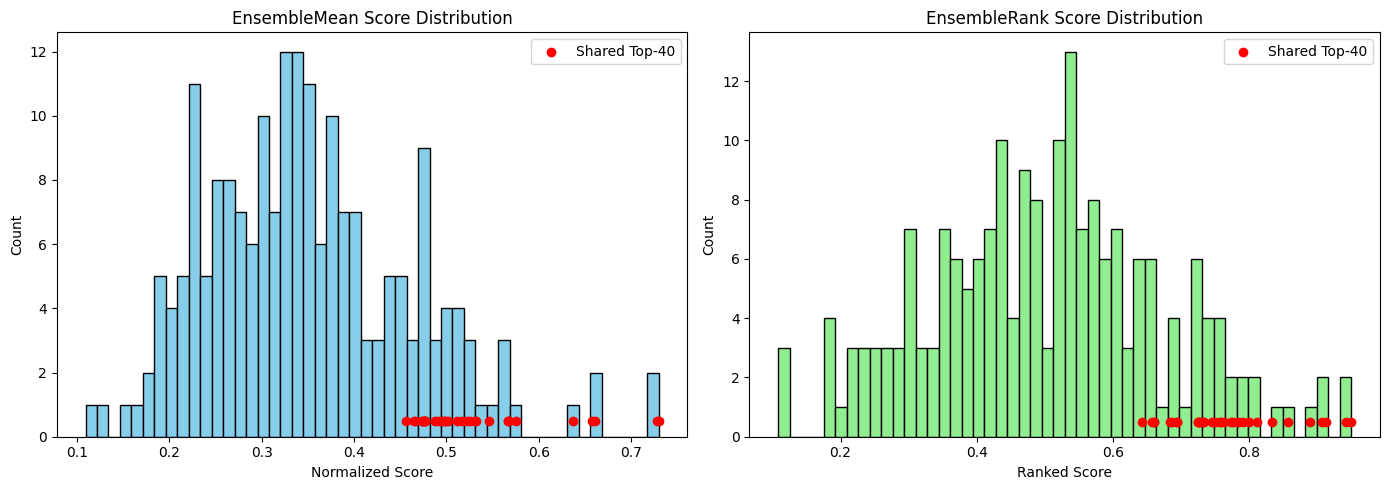

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 载入分数
mean_scores = np.load("ensemble_mean_scores.npy")
rank_scores = np.load("ensemble_rank_scores.npy")
common_topk_idx = np.load("common_topk_idx.npy")[:40]  # 共享 top-40

# 获取对应的分数
highlight_mean = mean_scores[common_topk_idx]
highlight_rank = rank_scores[common_topk_idx]

# 绘制分布直方图并叠加箭头或特殊点
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 方法1：EnsembleMean 分数分布
axs[0].hist(mean_scores, bins=50, color='skyblue', edgecolor='black')
axs[0].set_title("EnsembleMean Score Distribution")
axs[0].set_xlabel("Normalized Score")
axs[0].set_ylabel("Count")

# 高亮点：在 Mean Score 中标注共享 top-40 样本
axs[0].scatter(highlight_mean, [0.5]*len(highlight_mean), color='red', label='Shared Top-40', zorder=5)
axs[0].legend()

# 方法2：EnsembleRank 分数分布
axs[1].hist(rank_scores, bins=50, color='lightgreen', edgecolor='black')
axs[1].set_title("EnsembleRank Score Distribution")
axs[1].set_xlabel("Ranked Score")
axs[1].set_ylabel("Count")

# 高亮点：在 Rank Score 中标注共享 top-40 样本
axs[1].scatter(highlight_rank, [0.5]*len(highlight_rank), color='red', label='Shared Top-40', zorder=5)
axs[1].legend()

plt.tight_layout()
plt.savefig("highlighted_shared_top40.png")
plt.show()

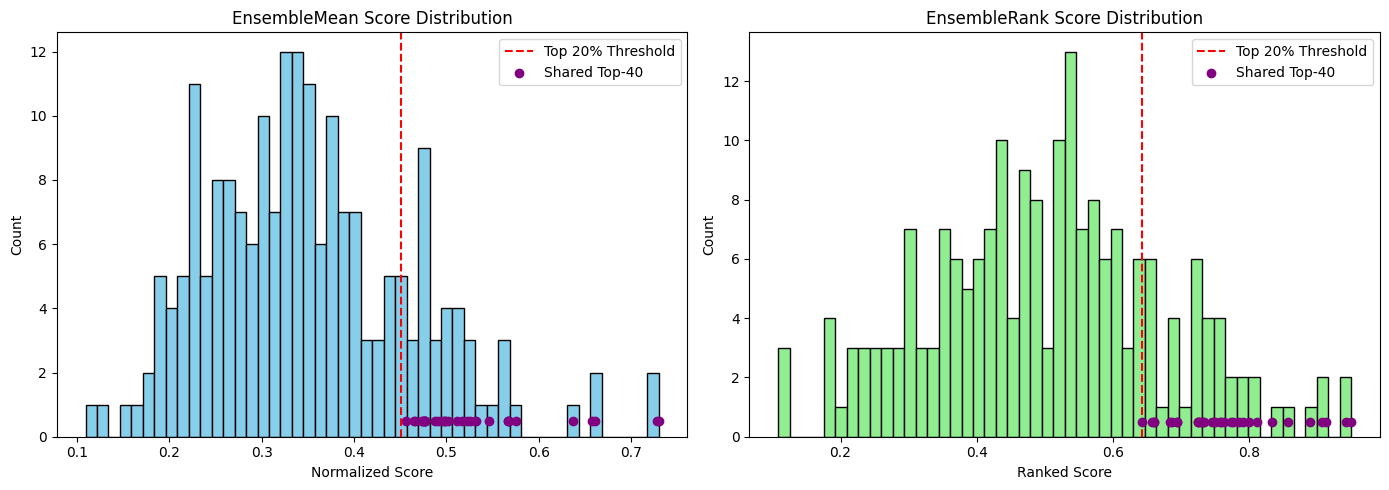

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 载入分数
mean_scores = np.load("ensemble_mean_scores.npy")
rank_scores = np.load("ensemble_rank_scores.npy")
common_topk_idx = np.load("common_topk_idx.npy")[:40]

# 获取对应的分数
highlight_mean = mean_scores[common_topk_idx]
highlight_rank = rank_scores[common_topk_idx]

# 计算 top-20% 分数阈值
mean_thresh = np.percentile(mean_scores, 80)
rank_thresh = np.percentile(rank_scores, 80)

# 绘图
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# 方法1：EnsembleMean
axs[0].hist(mean_scores, bins=50, color='skyblue', edgecolor='black')
axs[0].axvline(mean_thresh, color='red', linestyle='--', label='Top 20% Threshold')
axs[0].scatter(highlight_mean, [0.5]*len(highlight_mean), color='purple', label='Shared Top-40', zorder=5)
axs[0].set_title("EnsembleMean Score Distribution")
axs[0].set_xlabel("Normalized Score")
axs[0].set_ylabel("Count")
axs[0].legend()

# 方法2：EnsembleRank
axs[1].hist(rank_scores, bins=50, color='lightgreen', edgecolor='black')
axs[1].axvline(rank_thresh, color='red', linestyle='--', label='Top 20% Threshold')
axs[1].scatter(highlight_rank, [0.5]*len(highlight_rank), color='purple', label='Shared Top-40', zorder=5)
axs[1].set_title("EnsembleRank Score Distribution")
axs[1].set_xlabel("Ranked Score")
axs[1].set_ylabel("Count")
axs[1].legend()

plt.tight_layout()
plt.savefig("highlighted_top40_with_threshold.png")
plt.show()

In [5]:
# Baysian

In [6]:
# # approximation

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import norm

# # Step 1: Load VAE, TVAE, Diffusion scores
# vae = np.load("vae_scores.npy")
# tvae = np.load("tvae_scores.npy")
# diff = np.load("diff_mae_scores.npy")
# all_scores = np.stack([vae, tvae, diff], axis=1)

# # Step 2: Normalize scores to [0, 1]
# normalized = (all_scores - all_scores.min(axis=0)) / (all_scores.max(axis=0) - all_scores.min(axis=0) + 1e-8)

# # Step 3: Define binary threshold per model (top 20%)
# binary_preds = []
# for col in normalized.T:
#     thresh = np.percentile(col, 80)
#     binary_preds.append(col > thresh)
# binary_preds = np.stack(binary_preds, axis=1)  # shape: [n, 3]

# # Step 4: Estimate probability that sample is anomalous under majority vote
# # Use normal approximation to Poisson Binomial

# def approx_poibin_prob(p_vec, majority_k):
#     mu = np.sum(p_vec)
#     sigma_sq = np.sum(p_vec * (1 - p_vec))
#     sigma = np.sqrt(sigma_sq + 1e-6)
#     # Normal approximation with continuity correction
#     z = (majority_k - 0.5 - mu) / sigma
#     return 1 - norm.cdf(z)

# probs = []
# for row in normalized:
#     prob = approx_poibin_prob(row, majority_k=2)  # >=2/3 detectors vote abnormal
#     probs.append(prob)
# probs = np.array(probs)

# # Step 5: Threshold
# thresh = np.percentile(probs, 80)
# bayesian_mask = probs > thresh

# # Step 6: Save results
# np.save("bayesian_vote_probs.npy", probs)
# np.save("bayesian_vote_mask.npy", bayesian_mask)

# # Step 7: Visualization
# plt.hist(probs, bins=50, color='orchid', edgecolor='black')
# plt.axvline(thresh, color='red', linestyle='--', label="Top 20% threshold")
# plt.title("Bayesian Ensemble Voting Probability")
# plt.xlabel("Estimated P(Anomalous by majority)")
# plt.ylabel("Count")
# plt.legend()
# plt.tight_layout()
# plt.savefig("bayesian_vote_hist.png")
# plt.show()

# # Step 8: Print top-20 samples
# top_k = 20
# top_indices = np.argsort(-probs)[:top_k]
# print("\n🔝 Top-20 Anomalous Samples (Bayesian Voting):")
# for idx in top_indices:
#     print(f"Index: {idx}, P_majority = {probs[idx]:.4f}, Anomaly: {bayesian_mask[idx]}")

In [7]:
# # approximation

# import numpy as np
# import matplotlib.pyplot as plt

# # === Step 1: 载入数据 ===
# mean_scores = np.load("ensemble_mean_scores.npy")
# rank_scores = np.load("ensemble_rank_scores.npy")
# bayes_probs = np.load("bayesian_vote_probs.npy")
# common_top40 = np.load("common_topk_idx.npy")[:40]  # 共享 Top-40 索引

# # 共享样本在各分布中的分数
# highlight_mean = mean_scores[common_top40]
# highlight_rank = rank_scores[common_top40]
# highlight_bayes = bayes_probs[common_top40]

# # 各方法 top-20% 阈值
# thresh_mean = np.percentile(mean_scores, 80)
# thresh_rank = np.percentile(rank_scores, 80)
# thresh_bayes = np.percentile(bayes_probs, 80)

# # === Step 2: 画图 ===
# fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# # 方法1：EnsembleMean
# axs[0].hist(mean_scores, bins=50, color='skyblue', edgecolor='black')
# axs[0].axvline(thresh_mean, color='red', linestyle='--', label='Top 20% Threshold')
# axs[0].scatter(highlight_mean, [0.5]*len(highlight_mean), color='purple', label='Shared Top-40', zorder=5)
# axs[0].set_title("EnsembleMean Score Distribution")
# axs[0].set_xlabel("Normalized Score")
# axs[0].set_ylabel("Count")
# axs[0].legend()

# # 方法2：EnsembleRank
# axs[1].hist(rank_scores, bins=50, color='lightgreen', edgecolor='black')
# axs[1].axvline(thresh_rank, color='red', linestyle='--', label='Top 20% Threshold')
# axs[1].scatter(highlight_rank, [0.5]*len(highlight_rank), color='purple', label='Shared Top-40', zorder=5)
# axs[1].set_title("EnsembleRank Score Distribution")
# axs[1].set_xlabel("Ranked Score")
# axs[1].set_ylabel("Count")
# axs[1].legend()

# # 方法3：Bayesian Voting
# axs[2].hist(bayes_probs, bins=50, color='orchid', edgecolor='black')
# axs[2].axvline(thresh_bayes, color='red', linestyle='--', label='Top 20% Threshold')
# axs[2].scatter(highlight_bayes, [0.5]*len(highlight_bayes), color='purple', label='Shared Top-40', zorder=5)
# axs[2].set_title("Bayesian Voting Score Distribution")
# axs[2].set_xlabel("Estimated P(Anomalous by majority)")
# axs[2].set_ylabel("Count")
# axs[2].legend()

# plt.tight_layout()
# plt.savefig("combined_ensemble_top40_highlight.png")
# plt.show()


🔝 Top-10 anomalies by Majority Voting:
Index: 30, Score: 0.8507, Anomaly: True
Index: 181, Score: 0.8311, Anomaly: True
Index: 143, Score: 0.7441, Anomaly: True
Index: 21, Score: 0.7408, Anomaly: True
Index: 191, Score: 0.7112, Anomaly: True
Index: 165, Score: 0.6387, Anomaly: True
Index: 148, Score: 0.6028, Anomaly: True
Index: 24, Score: 0.6026, Anomaly: True
Index: 161, Score: 0.6020, Anomaly: True
Index: 59, Score: 0.5914, Anomaly: True


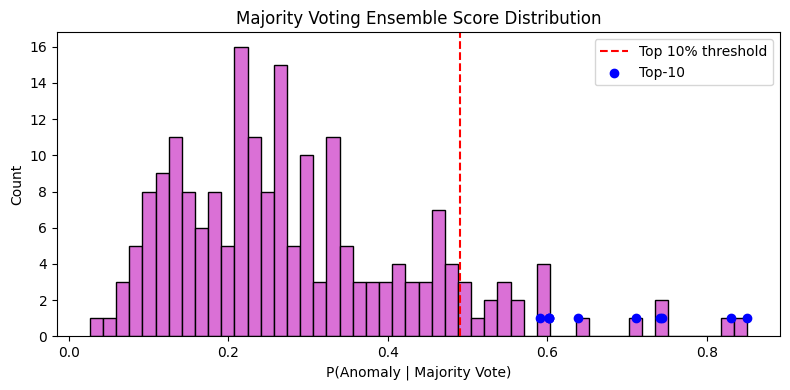

In [20]:
# bayesian_ensemble_poibin.ipynb

import numpy as np
import matplotlib.pyplot as plt
from poibin import PoiBin

# 1. Load individual model scores
vae_scores = np.load("vae_scores.npy")
tvae_scores = np.load("tvae_scores.npy")
diff_scores = np.load("diff_mae_scores.npy")

# 2. Normalize scores to [0, 1] range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
normalized_scores = scaler.fit_transform(np.vstack([vae_scores, tvae_scores, diff_scores]).T)

# 3. Bayesian Ensemble via Poisson Binomial
bayesian_scores = []
for i in range(normalized_scores.shape[0]):
    probs = normalized_scores[i]  # shape = (3,)
    pb = PoiBin(probs)
    p_majority = 1 - pb.cdf(1)  # P(at least 2 detectors think it's anomalous)
    bayesian_scores.append(p_majority)

bayesian_scores = np.array(bayesian_scores)
np.save("bayesian_poibin_scores.npy", bayesian_scores)

# 4. Identify top-20% as anomalies
threshold = np.percentile(bayesian_scores, 80)
anomaly_mask = bayesian_scores > threshold
np.save("bayesian_poibin_anomalies.npy", anomaly_mask)

# 5. Top-K reporting
K = 40
sorted_idx = np.argsort(-bayesian_scores)
print(f"\n🔝 Top-{K} anomalies by Majority Voting:")
for idx in sorted_idx[:K]:
    print(f"Index: {idx}, Score: {bayesian_scores[idx]:.4f}, Anomaly: {anomaly_mask[idx]}")

# 6. Visualization
plt.figure(figsize=(8, 4))
plt.hist(bayesian_scores, bins=50, color='orchid', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label='Top 20% threshold')
#plt.scatter(bayesian_scores[sorted_idx[:K]], [1]*K, color='blue', label='Top-10')
plt.title("Majority Voting Ensemble Score Distribution")
plt.xlabel("P(Anomaly | Majority Vote)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("bayesian_poibin_histogram.png")
plt.show()

In [5]:
import pandas as pd

# 1. Load your full dataset
df = pd.read_csv("/Users/salovjade/Desktop/Intern_2025/Project_1_Anomely_detection/data/sim_data_dm.csv")

# 2. Split into test set (last 200 rows)
test_df = df.iloc[9800:]  # 200 samples
feature_names = df.columns[1:]
test_X = test_df[feature_names].values  # shape = (200, num_features)

# 3. Extract vectors at index 30 and 181 in the test set
sample_30 = test_X[30]
sample_181 = test_X[181]

sample_128 = test_X[128]
sample_134 = test_X[134]

# 4. Optional: convert to pandas Series for readability
print("✅ Vector at index 128:\n", pd.Series(sample_128, index=feature_names))
print("\n✅ Vector at index 134:\n", pd.Series(sample_134, index=feature_names))

✅ Vector at index 128:
 EASI_wk0     22.000000
EASI_wk2     15.200000
EASI_wk4      9.200000
EASI_wk8     17.900000
EASI_wk12    25.600000
NRS_wk0       7.000000
NRS_wk2       7.142857
NRS_wk4       3.000000
NRS_wk8       3.000000
NRS_wk12      1.000000
IGA_wk0       3.000000
IGA_wk2       3.000000
IGA_wk4       2.000000
IGA_wk8       2.000000
IGA_wk12      3.000000
dtype: float64

✅ Vector at index 134:
 EASI_wk0     57.000000
EASI_wk2     27.600000
EASI_wk4     29.200000
EASI_wk8     29.000000
EASI_wk12    37.200000
NRS_wk0       8.000000
NRS_wk2       7.285714
NRS_wk4       6.000000
NRS_wk8       8.000000
NRS_wk12      5.000000
IGA_wk0       3.000000
IGA_wk2       3.000000
IGA_wk4       3.000000
IGA_wk8       4.000000
IGA_wk12      4.000000
dtype: float64


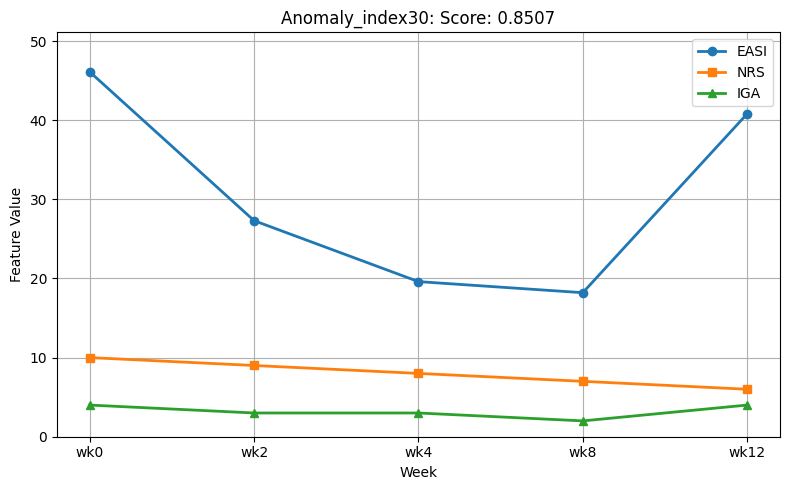

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 手动填入 index 30 的数据
weeks = ["wk0", "wk2", "wk4", "wk8", "wk12"]

EASI = [46.1, 27.3, 19.6, 18.2, 40.8]
NRS  = [10.0, 9.0, 8.0, 7.0, 6.0]
IGA  = [4.0, 3.0, 3.0, 2.0, 4.0]


# 可视化
plt.figure(figsize=(8, 5))
plt.plot(weeks, EASI, marker='o', label='EASI', linewidth=2)
plt.plot(weeks, NRS, marker='s', label='NRS', linewidth=2)
plt.plot(weeks, IGA, marker='^', label='IGA', linewidth=2)

plt.title("Anomaly_index30: Score: 0.8507")
plt.xlabel("Week")
plt.ylabel("Feature Value")
plt.ylim(0, max(EASI + NRS + IGA) + 5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Anomaly_index30_plot.png")
plt.show()

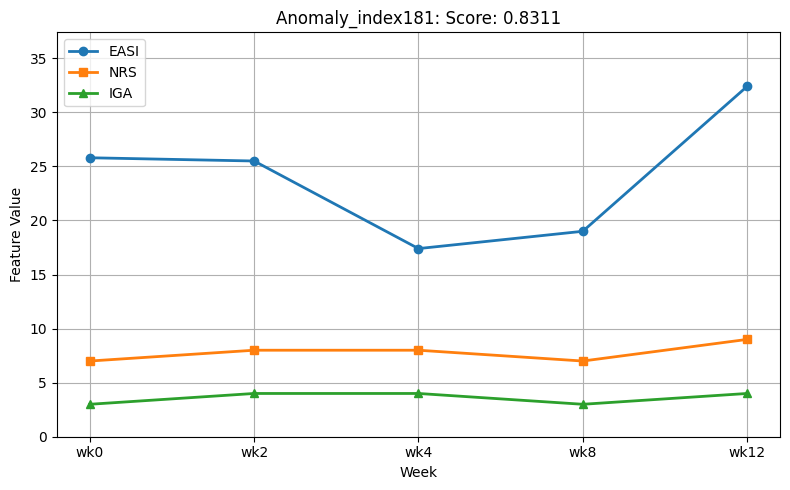

In [16]:
import matplotlib.pyplot as plt

# 时间点
weeks = ["wk0", "wk2", "wk4", "wk8", "wk12"]

# Index 181 的数据
EASI = [25.8, 25.5, 17.4, 19.0, 32.4]
NRS  = [7.0, 8.0, 8.0, 7.0, 9.0]
IGA  = [3.0, 4.0, 4.0, 3.0, 4.0]

# 可视化
plt.figure(figsize=(8, 5))
plt.plot(weeks, EASI, marker='o', label='EASI', linewidth=2)
plt.plot(weeks, NRS, marker='s', label='NRS', linewidth=2)
plt.plot(weeks, IGA, marker='^', label='IGA', linewidth=2)

plt.title("Anomaly_index181: Score: 0.8311")
plt.xlabel("Week")
plt.ylabel("Feature Value")
plt.ylim(0, max(EASI + NRS + IGA) + 5)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("index181_longitudinal_plot.png")
plt.show()

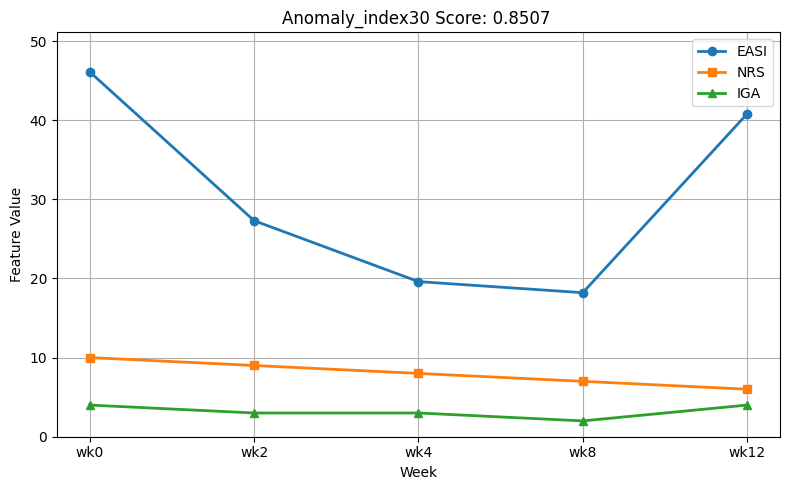

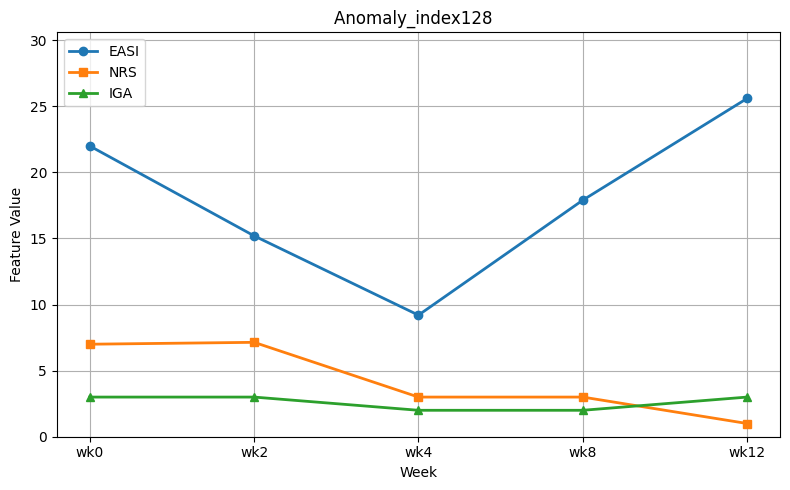

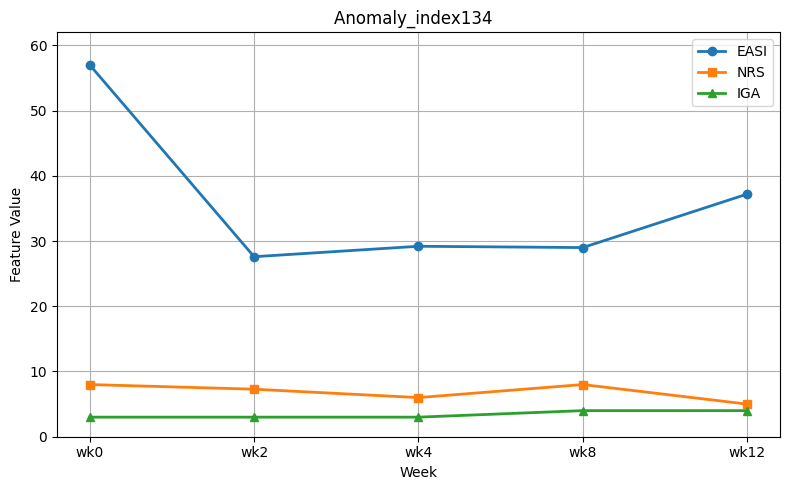

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 周次标签
weeks = ["wk0", "wk2", "wk4", "wk8", "wk12"]

# 各 index 的数据
data = {
    30: {
        "EASI": [46.1, 27.3, 19.6, 18.2, 40.8],
        "NRS":  [10.0, 9.0, 8.0, 7.0, 6.0],
        "IGA":  [4.0, 3.0, 3.0, 2.0, 4.0],
        "score": 0.8507
    },
    128: {
        "EASI": [22.0, 15.2, 9.2, 17.9, 25.6],
        "NRS":  [7.0, 7.142857, 3.0, 3.0, 1.0],
        "IGA":  [3.0, 3.0, 2.0, 2.0, 3.0],
        "score": None  # 如果你有 anomaly score 可以补上
    },
    134: {
        "EASI": [57.0, 27.6, 29.2, 29.0, 37.2],
        "NRS":  [8.0, 7.285714, 6.0, 8.0, 5.0],
        "IGA":  [3.0, 3.0, 3.0, 4.0, 4.0],
        "score": None
    }
}

# 逐个画图
for idx, values in data.items():
    EASI, NRS, IGA = values["EASI"], values["NRS"], values["IGA"]
    score_str = f"Score: {values['score']:.4f}" if values["score"] is not None else ""
    
    plt.figure(figsize=(8, 5))
    plt.plot(weeks, EASI, marker='o', label='EASI', linewidth=2)
    plt.plot(weeks, NRS, marker='s', label='NRS', linewidth=2)
    plt.plot(weeks, IGA, marker='^', label='IGA', linewidth=2)

    plt.title(f"Anomaly_index{idx} {score_str} ")
    plt.xlabel("Week")
    plt.ylabel("Feature Value")
    plt.ylim(0, max(EASI + NRS + IGA) + 5)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"Anomaly_index{idx}_plot.png")
    plt.show()


🔝 Top-40 anomalies by Majority Voting:
Index: 30, Score: 0.8507, Anomaly: True
Index: 181, Score: 0.8311, Anomaly: True
Index: 143, Score: 0.7441, Anomaly: True
Index: 21, Score: 0.7408, Anomaly: True
Index: 191, Score: 0.7112, Anomaly: True
Index: 165, Score: 0.6387, Anomaly: True
Index: 148, Score: 0.6028, Anomaly: True
Index: 24, Score: 0.6026, Anomaly: True
Index: 161, Score: 0.6020, Anomaly: True
Index: 59, Score: 0.5914, Anomaly: True
Index: 70, Score: 0.5665, Anomaly: True
Index: 198, Score: 0.5650, Anomaly: True
Index: 104, Score: 0.5528, Anomaly: True
Index: 64, Score: 0.5453, Anomaly: True
Index: 141, Score: 0.5446, Anomaly: True
Index: 12, Score: 0.5351, Anomaly: True
Index: 177, Score: 0.5333, Anomaly: True
Index: 20, Score: 0.5136, Anomaly: True
Index: 7, Score: 0.5004, Anomaly: True
Index: 76, Score: 0.4992, Anomaly: True
Index: 128, Score: 0.4899, Anomaly: True
Index: 135, Score: 0.4867, Anomaly: True
Index: 196, Score: 0.4838, Anomaly: True
Index: 38, Score: 0.4816, An

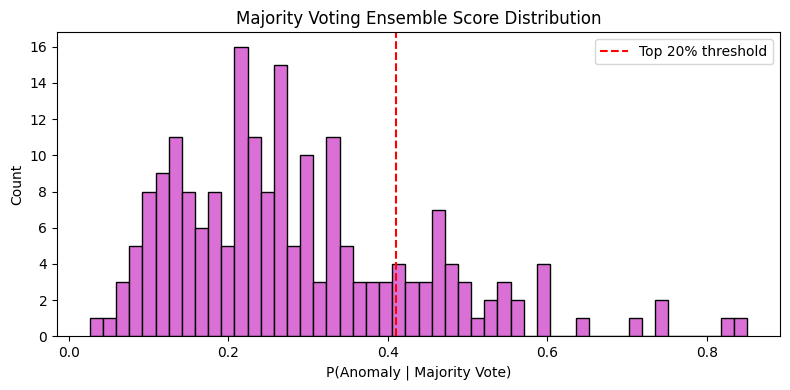

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Poisson Binomial anomaly scores
bayesian_scores = np.load("bayesian_poibin_scores.npy")  # shape = (200,)
threshold = np.percentile(bayesian_scores, 80)
anomaly_mask = bayesian_scores > threshold


# 5. Top-K reporting
K = 40
sorted_idx = np.argsort(-bayesian_scores)
print(f"\n🔝 Top-{K} anomalies by Majority Voting:")
for idx in sorted_idx[:K]:
    print(f"Index: {idx}, Score: {bayesian_scores[idx]:.4f}, Anomaly: {anomaly_mask[idx]}")

# 6. Visualization
plt.figure(figsize=(8, 4))
plt.hist(bayesian_scores, bins=50, color='orchid', edgecolor='black')
plt.axvline(threshold, color='red', linestyle='--', label='Top 20% threshold')
#plt.scatter(bayesian_scores[sorted_idx[:K]], [1]*K, color='blue', label='Top-10')
plt.title("Majority Voting Ensemble Score Distribution")
plt.xlabel("P(Anomaly | Majority Vote)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.savefig("bayesian_poibin_histogram.png")
plt.show()

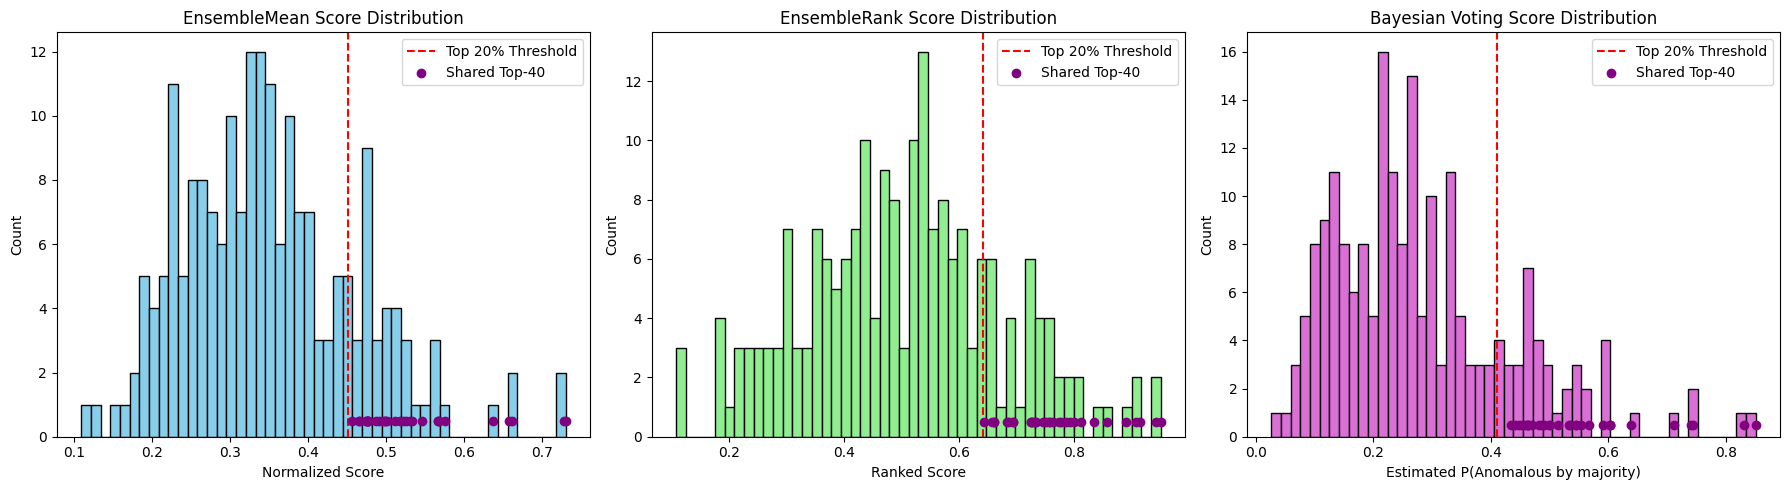

In [21]:
import numpy as np
import matplotlib.pyplot as plt

from poibin import PoiBin

# Step 0: 载入原始模型分数
vae = np.load("vae_scores.npy")
tvae = np.load("tvae_scores.npy")
diff = np.load("diff_mae_scores.npy")
all_scores = np.stack([vae, tvae, diff], axis=1)

# Step 0.1: Normalize [0, 1]
normalized = (all_scores - all_scores.min(axis=0)) / (all_scores.max(axis=0) - all_scores.min(axis=0) + 1e-8)

# Step 0.2: Compute Bayesian P(≥2 detectors say anomaly) using FFT Poisson Binomial
bayes_probs = []
for i in range(normalized.shape[0]):
    p = normalized[i]
    pb = PoiBin(p)
    prob = 1 - pb.cdf(1)  # Probability of ≥2 out of 3
    bayes_probs.append(prob)
bayes_probs = np.array(bayes_probs)

# Step 0.3: Save if needed
np.save("bayesian_vote_probs_fft.npy", bayes_probs)

# === Step 1: 载入数据 ===
mean_scores = np.load("ensemble_mean_scores.npy")
rank_scores = np.load("ensemble_rank_scores.npy")

common_top40 = np.load("common_topk_idx.npy")[:40]  # 共享 Top-40 索引

# 共享样本在各分布中的分数
highlight_mean = mean_scores[common_top40]
highlight_rank = rank_scores[common_top40]
highlight_bayes = bayes_probs[common_top40]

# 各方法 top-20% 阈值
thresh_mean = np.percentile(mean_scores, 80)
thresh_rank = np.percentile(rank_scores, 80)
thresh_bayes = np.percentile(bayes_probs, 80)

# === Step 2: 画图 ===
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# 方法1：EnsembleMean
axs[0].hist(mean_scores, bins=50, color='skyblue', edgecolor='black')
axs[0].axvline(thresh_mean, color='red', linestyle='--', label='Top 20% Threshold')
axs[0].scatter(highlight_mean, [0.5]*len(highlight_mean), color='purple', label='Shared Top-40', zorder=5)
axs[0].set_title("EnsembleMean Score Distribution")
axs[0].set_xlabel("Normalized Score")
axs[0].set_ylabel("Count")
axs[0].legend()

# 方法2：EnsembleRank
axs[1].hist(rank_scores, bins=50, color='lightgreen', edgecolor='black')
axs[1].axvline(thresh_rank, color='red', linestyle='--', label='Top 20% Threshold')
axs[1].scatter(highlight_rank, [0.5]*len(highlight_rank), color='purple', label='Shared Top-40', zorder=5)
axs[1].set_title("EnsembleRank Score Distribution")
axs[1].set_xlabel("Ranked Score")
axs[1].set_ylabel("Count")
axs[1].legend()

# 方法3：Bayesian Voting
axs[2].hist(bayes_probs, bins=50, color='orchid', edgecolor='black')
axs[2].axvline(thresh_bayes, color='red', linestyle='--', label='Top 20% Threshold')
axs[2].scatter(highlight_bayes, [0.5]*len(highlight_bayes), color='purple', label='Shared Top-40', zorder=5)
axs[2].set_title("Bayesian Voting Score Distribution")
axs[2].set_xlabel("Estimated P(Anomalous by majority)")
axs[2].set_ylabel("Count")
axs[2].legend()

plt.tight_layout()
plt.savefig("combined_ensemble_top40_highlight.png")
plt.show()